## 决策树三种算法
- ID3：特征划分基于信息增益  
- C4.5：特征划分基于信息增益比
- CART：特征划分基于基尼指数

决策树的流程为：

　　(1)输入需要分类的数据集和类别标签和靶标签。

　　(2)检验数据集是否只有一列，或者是否最后一列(靶标签数据默认放到最后一列)只有一个水平(唯一值)。

　　　　是：返回唯一值水平或者占比最大的那个水平

　　(3)调用信息增益公式，计算所有节点的信息增益，得到最大信息增益所对应的类别标签。

　　(4)建立决策树字典用以保存当次叶节点数据信息。

　　(5)进入循环：

　　　　按照该类别标签的不同水平，依次计算子数据集；

　　　　对子数据集重复(1),(2),(3),(4),(5), (6)步。

　　(6)返回决策树字典。

决策树实际上是一个大的递归函数，其结果是一个多层次的字典。

## ID3

In [67]:
import pandas as pd
import numpy as np
import json

# class LoadDataSet(object):
#     def load_dataSet(self):
#         data = pd.read_csv('./ID3data.txt', sep='\t', header=None)
#         data.rename(columns={0: 'age', 1: 'income', 2: 'student', 3: 'reputation', 4: 'purchase'},inplace=True)
#         return data

# # 用来加载和存储训练的模型
# class TreeHandler(object):
#     def __init__(self):
#         self.tree = None
#     def save(self, tree):
#         self.tree = tree
#         with open('tree.txt', mode='w', encoding='utf-8') as f:
#             tree = json.dumps(tree, indent=" ", ensure_ascii=False) # ensure_ascii=False 可以输出中文
#             f.write(tree)
#     def load(self, file):
#         with open(file, mode='r', encoding='utf-8') as f:
#             tree = f.read()
#             self.tree = json.loads(tree)
#         return self.tree
    
# ID3
class ID3Tree(object):
    def __init__(self):
        self.__count = 0
        self.tree = {}
        self.InfoGain = {}
    def _entropy(self, dataSet):
        # 计算给定数据集的熵
        labels = dataSet.columns.tolist()
        # 统计分类标签不同水平的值
        level_count = dataSet[labels[-1]].value_counts().to_dict()
        entropy = 0
        for level, nums in level_count.items():
            prob = float(nums) / dataSet.shape[0]
            entropy += -prob * np.log2(prob)
        return entropy
    def _split_dataSet(self, dataSet, best_label, level):
        # 根据给定的特征label和其分类level来获取新的子数据集
        subdata = dataSet[dataSet[best_label] == level]
        
        # 去掉best_label这一列，重置索引,drop=True去掉原索引
        del subdata[best_label]
        subdata.reset_index(drop=True, inplace=True)
        return subdata
        
    def _best_split(self, dataSet):
        # 计算每个特征的信息增益
        best_infoGain = 0.0
        best_label = None
        
        labels = dataSet.columns.tolist()[:-1]
        Entropy_S = self._entropy(dataSet) # 把标签的熵
        # label是新加的特征，level是label下的分类
        for index, label in enumerate(labels):
            levels = dataSet[label].unique().tolist()
            label_entropy = 0.0
            for level in levels:
                level_data = dataSet[dataSet[label] == level]
                prob = level_data.shape[0] / dataSet.shape[0]
                label_entropy += prob * self._entropy(level_data)
            infoGain = Entropy_S - label_entropy
            if infoGain > best_infoGain:
                best_infoGain = infoGain
                best_label = label
            self.InfoGain.setdefault(self.__count, {}) # 保存{__count: {label1: infoGain1, label2: infoGain2, ...}}
            self.InfoGain[self.__count][label] = infoGain
        self.__count += 1
        return best_label
    
    def _top_amount_level(self, target_list):
        level_count = target_list.unique().value_counts().to_dict()
        sorted_level_count = sorted(level_count.items(), key=lambda x: x[1], reverse=True)
        return sorted_level_count[0][0]
    
    def mktree(self, dataSet):
        target_list = dataSet.iloc[:, -1] # 靶标签的那一列数据
#         # 程序终止条件一：靶标签在该数据集上只有一个值(全部归为1类)，返回该值
#         if target_list.unique().shape[0] == 1:
#             return target_list[0]
        
#         # 程序终止条件二：数据集只剩下靶标签这一列，返回靶标签上数量最多的水平,这是将所有的都归为这一类，少数服从多数
#         if dataSet.shape[0] == 1:
#             return self._top_amount_level(dataSet)
        
#         # 递归
#         # 选择最佳分类特征
#         best_label = self._best_split(dataSet)
        
#         # 在选择的特征下面选择分类
#         best_label_levels = dataSet[best_label].unique().tolist()
#         tree[best_label] = {} # 生成字典，保存树分类信息
#         for level in best_label_levels:
#             level_subdata = self._split_dataSet(dataSet, best_label, level) #params: 原数据， 信息增益最大的特征， 特性下的分类level
#             tree[best_label][level] = self.mktree(level_subdata)
#         return tree
        target_list = dataSet.iloc[:, -1] # 靶标签的那一列数据
        # 程序终止条件一：靶标签在该数据集上只有一个值(全部归为1类)，返回该值
        if target_list.unique().shape[0] <= 1:
            return target_list[0]
        
        # 程序终止条件二：数据集只剩下靶标签这一列，返回靶标签上数量最多的水平,这是将所有的都归为这一类，少数服从多数
        if dataSet.shape[0] == 1:
            return self._top_amount_level(dataSet)
        
        # 递归
        # 选择最佳分类特征
        best_label = self._best_split(dataSet)
        
        # 在选择的特征下面选择分类
        best_label_levels = dataSet[best_label].unique().tolist()
        self.tree = {best_label: {}} # 生成字典，保存树分类信息
        for level in best_label_levels:
            level_subdata = self._split_dataSet(dataSet, best_label, level) #params: 原数据， 信息增益最大的特征， 特性下的分类level
            self.tree[best_label] = {level: self.mktree(level_subdata)}
    
    def predict(self, tree, labels, test_samples):
        '''
        tree: trained model, a dict
        labels: all features
        '''
        firstStr = list(tree.keys())[0]
        secondDict = tree[firstStr]
        featIndex = labels.index(firstStr) # 找到第一个特征label在labels上的索引
        for key in secondDict.keys():
            if test_samples[featIndex] == key:
                if secondDict[key].__class__.__name__ == "dict":
                    classLabel = self.predict(secondDict[key], labels, test_samples)
                else:
                    classLabel = secondDict[key]
    
    def predict(self, tree, labels, test_samples):
        '''
        tree: trained model, a dict
        labels: all features
        '''
        firstStr = list(tree.keys())[0]
        secondDict = tree[firstStr]
        featIndex = labels.index(firstStr) # 找到第一个特征label在labels上的索引
        for key in secondDict.keys():
            if test_samples[featIndex] == key:
                if secondDict[key].__class__.__name__ == "dict":
                    classLabel = self.predict(secondDict[key], labels, test_samples)
                else:
                    classLabel = secondDict[key]
        return classLabel
        
    def _unit_test(self):
        """用于测试_entropy函数"""
        data = [[1, 1, "yes"], 
                [1, 1, "yes"],
                [1, 0, "no"],
                [0, 1, "no"],
                [0, 1, "no"],]
        data = pd.DataFrame(data=data, columns=["a", "b", "c"])
        self.tree = self.mktree(self.dataSet)
        labels = ["age", "income", "student", "reputation"]
        test_sample = [0, 1, 0, 1]   # [0, 1, 0, 0, "no"]
        output = self.predict(self.tree, labels, test_sample)
        print("The truth class is %s, The ID3Tree outcome is %s." % ("no", output))
data = pd.read_csv('./ID3data.txt', sep='\t', header=None)
data.rename(columns={0: 'age', 1: 'income', 2: 'student', 3: 'reputation', 4: 'purchase'},inplace=True)
data.head()
model = ID3Tree()
model.mktree(data)
model.tree
# print(model.tree)

# labels = model.predict(labels=["age", "income", "student", "reputation"], test_samples=[0, 1, 0, 1])
# labels
model = ID3Tree()
model.mktree(data)

In [ ]:
# 定义节点类 二叉树
class Node:
    def __init__(self, root=True, label=None, feature_name=None, feature=None):
        self.root = root
        self.label = label
        self.feature_name = feature_name
        self.feature = feature
        self.tree = {}
        self.result = {'label:': self.label, 'feature': self.feature, 'tree': self.tree}

    def __repr__(self):
        return '{}'.format(self.result)

    def add_node(self, val, node):
        self.tree[val] = node

    def predict(self, features):
        if self.root is True:
            return self.label
        return self.tree[features[self.feature]].predict(features)
    
class DTree:
    def __init__(self, epsilon=0.1):
        self.epsilon = epsilon
        self._tree = {}

    # 熵
    @staticmethod
    def calc_ent(datasets):
        data_length = len(datasets)
        label_count = {}
        for i in range(data_length):
            label = datasets[i][-1]
            if label not in label_count:
                label_count[label] = 0
            label_count[label] += 1
        ent = -sum([(p/data_length)*log(p/data_length, 2) for p in label_count.values()])
        return ent

    # 经验条件熵
    def cond_ent(self, datasets, axis=0):
        data_length = len(datasets)
        feature_sets = {}
        for i in range(data_length):
            feature = datasets[i][axis]
            if feature not in feature_sets:
                feature_sets[feature] = []
            feature_sets[feature].append(datasets[i])
        cond_ent = sum([(len(p)/data_length)*self.calc_ent(p) for p in feature_sets.values()])
        return cond_ent

    # 信息增益
    @staticmethod
    def info_gain(ent, cond_ent):
        return ent - cond_ent

    def info_gain_train(self, datasets):
        count = len(datasets[0]) - 1
        ent = self.calc_ent(datasets)
        best_feature = []
        for c in range(count):
            c_info_gain = self.info_gain(ent, self.cond_ent(datasets, axis=c))
            best_feature.append((c, c_info_gain))
        # 比较大小
        best_ = max(best_feature, key=lambda x: x[-1])
        return best_

    def train(self, train_data):
        """
        input:数据集D(DataFrame格式)，特征集A，阈值eta
        output:决策树T
        """
        _, y_train, features = train_data.iloc[:, :-1], train_data.iloc[:, -1], train_data.columns[:-1]
        # 1,若D中实例属于同一类Ck，则T为单节点树，并将类Ck作为结点的类标记，返回T
        if len(y_train.value_counts()) == 1:
            return Node(root=True,
                        label=y_train.iloc[0])

        # 2, 若A为空，则T为单节点树，将D中实例树最大的类Ck作为该节点的类标记，返回T
        if len(features) == 0:
            return Node(root=True, label=y_train.value_counts().sort_values(ascending=False).index[0])

        # 3,计算最大信息增益 同5.1,Ag为信息增益最大的特征
        max_feature, max_info_gain = self.info_gain_train(np.array(train_data))
        max_feature_name = features[max_feature]

        # 4,Ag的信息增益小于阈值eta,则置T为单节点树，并将D中是实例数最大的类Ck作为该节点的类标记，返回T
        if max_info_gain < self.epsilon:
            return Node(root=True, label=y_train.value_counts().sort_values(ascending=False).index[0])

        # 5,构建Ag子集
        node_tree = Node(root=False, feature_name=max_feature_name, feature=max_feature)

        feature_list = train_data[max_feature_name].value_counts().index
        for f in feature_list:
            sub_train_df = train_data.loc[train_data[max_feature_name] == f].drop([max_feature_name], axis=1)

            # 6, 递归生成树
            sub_tree = self.train(sub_train_df)
            node_tree.add_node(f, sub_tree)

        # pprint.pprint(node_tree.tree)
        return node_tree

    def fit(self, train_data):
        self._tree = self.train(train_data)
        return self._tree

    def predict(self, X_test):
        return self._tree.predict(X_test)

## CART(Classification And Regression Trees) 分类树

CART分类树：
 {'PetalWidth': {'0.20': 'setosa', '不为0.20': {'PetalLength': {'1.50': 'setosa', '不为1.50': {'SepalLength': {'5.60': 'versicolor', '不为5.60': {'SepalWidth': {'2.80': 'versicolor', '不为2.80': 'setosa'}}}}}}}}


/Users/algaber/.local/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['SimHei'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


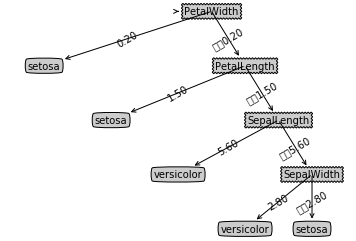

In [12]:
# CART分类树
import numpy as np  
import pandas as pd 
import matplotlib.pyplot as plt  
import matplotlib
from collections import Counter

matplotlib.rcParams['font.family'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False

decisionNode = dict(boxstyle='sawtooth', fc='0.8')
leafNode = dict(boxstyle='round4', fc='0.8')
arrow_args = dict(arrowstyle='<-')

# calculate gini
def calcGini(dataSet):
    y_labels = np.unique(dataSet.iloc[:, -1])
    numSamples = len(dataSet)
    y_p = {} # 每一个分类的概率
    gini = 1 # gini = 1 - p_i**2
    for label in y_labels:
        y_p[label] = len(dataSet[dataSet.iloc[:, -1] == label]) / numSamples
        gini -= y_p[label] ** 2
    return gini

# 划分数据集
def splitDataSet(dataSet, feat, level, types=1):
    if types == 1: # 使用此特征feat中的level进行划分
        subDataSet = dataSet[dataSet.iloc[:, feat] == level]
    elif types == 2:
        subDataSet = dataSet[dataSet.iloc[:, feat] != level]
    return subDataSet, len(subDataSet)

# 计算Gini指数，选择最好的特征划分数据集，返回最佳特征下标和最佳分区，Gini指数字典
def chooseBestFeature(dataSet, types='Gini'):
    numSamples = dataSet.shape[0]
    numFeatures = dataSet.shape[1] - 1
    bestFeature = -1
    columnFeatGini = {}
    for i in range(numFeatures):
        d = dataSet.iloc[:, i].value_counts().to_dict() # {level1: count1, level2: count2, ...}
        for level, n in d.items():
            conditionGini = 0.0 # 类似条件熵
            bestFlag = 1.00001
            subdataSet1, sublen1 = splitDataSet(dataSet, i, level, 1)
            subDataSet2, sublen2 = splitDataSet(dataSet, i, level, 2)
            if (sublen1 / numSamples) * calcGini(subdataSet1) == 0: # 表示这一个特征已经所有的level值都归为1类 
                bestFlag = 1
            conditionGini += (sublen1 / numSamples) * calcGini(subdataSet1) + (sublen2 / numSamples) * calcGini(subDataSet2) 

            columnFeatGini['%d_%f'%(i, level)] = conditionGini * bestFlag
    bestFeature = min(columnFeatGini, key=columnFeatGini.get) # 找到字典最小值的key
    return bestFeature,columnFeatGini

def createTree(dataSet, feat, types='Gini'):
    y_labels = np.unique(dataSet.iloc[:, -1])

    #1.如果数据集D中的所有实例都属于同一类label，则T为单节点树，将label作为该节点的类标记，返回T
    if len(set(y_labels)) == 1:
        return y_labels[0]

    #2.若只剩下label列，返回label中出现次数最大的level，返回T
    if dataSet.shape[1] == 1:
        array = np.array(dataSet)
        label_dict = {}
        for level in np.unique(array).tolist():
            label_dict[level] = len(array[array == level])
        return max(label_dict, key=label_dict.get)

    #3.CART,选择Gini指数最小的特征bestFeature进行划分
    bestFeature, columnFeatGini = chooseBestFeature(dataSet, types)

    bestFeatureLabel = feat[int(bestFeature.split('_')[0])] # feature val
    bestFeatureIndex = int(bestFeature.split('_')[0]) # index
    bestFeatureLevel = float(bestFeature.split('_')[1])
    decisionTree = {bestFeatureLabel: {}}
    # 使用bestFeauture进行划分，产生两个节点
    y_label_split_dict = dataSet[ dataSet.iloc[:, bestFeatureIndex] == bestFeatureLevel].iloc[:, -1].value_counts().to_dict()
    y_leaf = max(y_label_split_dict, key=y_label_split_dict.get) # yes | no
    decisionTree[bestFeatureLabel]['{:.2f}'.format(bestFeatureLevel)] = y_leaf # 左枝叶子值

    #4. 删除此最优划分数据样本，用其他样本递归1-3，得到树   
    subDataSet = dataSet.drop(bestFeatureLabel, axis=1)
    feat.pop(bestFeatureIndex)
    subfeat = feat

    # 判断右支类型，划分后左枝右枝不定,且CART树只有两个分类
    y1 = y_labels[0]
    y2 = y_labels[1]
    if y_leaf == y1:
        decisionTree[bestFeatureLabel]["不为{:.2f}".format(bestFeatureLevel)] = {}
        decisionTree[bestFeatureLabel]["不为{:.2f}".format(bestFeatureLevel)] = createTree(subDataSet, subfeat, types)
    elif y_leaf == y2:
        decisionTree[bestFeatureLabel]["不为{:.2f}".format(bestFeatureLevel)] = {}
        decisionTree[bestFeatureLabel]["不为{:.2f}".format(bestFeatureLevel)] = createTree(subDataSet, subfeat, types)

    return decisionTree

def getNumLeafs(myTree):
    numLeafs = 0
    firstStr = list(myTree.keys())[0]
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        if isinstance(secondDict[key], dict):
            numLeafs += getNumLeafs(secondDict[key])
        else:
            numLeafs += 1
    return numLeafs

def getTreeDepth(myTree):
    maxDepth = 0
    firstStr = list(myTree.keys())[0]
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        if isinstance(secondDict[key], dict):
            current_depth = 1 + getTreeDepth(secondDict[key])
        else:
            current_depth = 1
        maxDepth = current_depth if current_depth > maxDepth else maxDepth
    return maxDepth

# def plotNode(nodeTxt, centerPt, parentPt, nodeType):
#     createPlot.ax1.annotate(nodeTxt, xy=parentPt, xycoords='axes fraction', xytext=centerPt, 
#                             textcoords='axes fraction',va='center', ha='center', bbox=nodeType, arrowprops=arraw_args)
def plotNode(nodeTxt, centerPt, parentPt, nodeType):
    createPlot.ax1.annotate(nodeTxt, xy=parentPt,  xycoords='axes fraction',
             xytext=centerPt, textcoords='axes fraction',
             va="center", ha="center", bbox=nodeType, arrowprops=arrow_args )

    
def plotMidText(cntrPt, parentPt, txtString):
    xMid = (parentPt[0] - cntrPt[0]) / 2.0 + cntrPt[0]
    yMid = (parentPt[1]- cntrPt[1]) / 2.0 + cntrPt[1]
    createPlot.ax1.text(xMid, yMid, txtString, va='center', ha='center', rotation=30)
    
def plotTree(myTree, parentPt, nodeTxt):
    numLeafs = getNumLeafs(myTree)
    firstStr = list(myTree.keys())[0]
    cntrPt = (plotTree.xOff + (1.0 + float(numLeafs) / 2.0) / plotTree.totalW, plotTree.yOff)
    plotMidText(cntrPt, parentPt, nodeTxt)
    plotNode(firstStr, cntrPt, parentPt, decisionNode)
    secondDict = myTree[firstStr]
    plotTree.yOff = plotTree.yOff - 1.0/plotTree.totalD
    for key in secondDict.keys():
        if isinstance(secondDict[key], dict):#test to see if the nodes are dictonaires, if not they are leaf nodes   
            plotTree(secondDict[key],cntrPt,str(key))        #recursion
        else:   #it's a leaf node print the leaf node
            plotTree.xOff = plotTree.xOff + 1.0/plotTree.totalW
            plotNode(secondDict[key], (plotTree.xOff, plotTree.yOff), cntrPt, leafNode)
            plotMidText((plotTree.xOff, plotTree.yOff), cntrPt, str(key))
    plotTree.yOff = plotTree.yOff + 1.0/plotTree.totalD

#if you do get a dictonary you know it's a tree, and the first element will be another dict
def createPlot(myTree):
    fig = plt.figure(1, facecolor='white') # facecolor背景色， 1为绘图编号
    fig.clf() #clf() 清除当前figure的所有axes，但是不关闭这个window，所以能继续复用于其他的plot
    axprops = dict(xticks=[], yticks=[])
    createPlot.ax1 = plt.subplot(111, frame_on=False, **axprops)
    plotTree.totalW = float(getNumLeafs(myTree))
    plotTree.totalD = float(getTreeDepth(myTree))
    plotTree.xOff = -0.5 / plotTree.totalW
    plotTree.yOff = 1.0
    plotTree(myTree, (0.5, 1.0), '')
    plt.show()

if __name__ == "__main__":  
    df_data=pd.read_csv('./data.csv')
    features = list(df_data.columns[0:-1]) # 特征
    dataSet= df_data
    bestFeature,columnFeaGini=chooseBestFeature(dataSet,'Gini')
#     print('\nbestFeature:',bestFeature,'\nGini(D,A):',columnFeaGini)
    dt_Gini = createTree(dataSet, features, 'Gini')   #建立决策树，CART分类树
    print( 'CART分类树：\n',dt_Gini)
    # 画出决策树
    createPlot(dt_Gini)



## CART(Classification And Regression Trees) 回归树

In [11]:
# CART回归树
# label是连续值

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

# 最小二乘损失
def calcErr(dataSet):
    # ( y-y_mean() ) ** 2
    return np.var(dataSet.iloc[:, -1]) * dataSet.shape[0]

# 划分数据集，按输入的数据列feat，数据值val将数据划分为两部分
def splitDataSet(dataSet, feat, value):
    subDataSet1 = dataSet[dataSet.iloc[:, feat] <= value]
    subDataSet2 = dataSet[dataSet.iloc[:, feat] > value]
    return subDataSet1, subDataSet2

# 选择最好的特征划分数据集，min_samples每次划分后每部分最少的样本数，epsilon误差下降阈值，值越小划分越细
# return bestFeat, bestValue,得到最佳的切分集合
def chooseBestFeature(dataSet, min_samples=4, epsilon=0.5):
    featNums = dataSet.shape[1] - 1
    samplesNums = dataSet.shape[0]
    Err_D = calcErr(dataSet)
    minErr = np.inf
    bestFeat = 0 
    bestValue = 0
    currentErr = 0
    #1.数据全是一类的情况，返回
    if len(set(dataSet.iloc[:, -1])) == 1:
        return None, dataSet.iloc[-1, -1]

    for feat in range(0, featNums):
        for sample in range(0, samplesNums):
            currentValue = dataSet.iloc[sample, feat]
            subDataSet1, subDataSet2 = splitDataSet(dataSet, feat, currentValue)
            if len(subDataSet1) < min_samples or len(subDataSet2) < min_samples:
                continue
            currentErr = calcErr(subDataSet1) + calcErr(subDataSet2)
            if currentErr < minErr:
                minErr = currentErr
                bestValue = currentValue
                bestFeat = feat

    #2.新的划分点对当前样本误差下降较小，停止切分,返回
    if (Err_D - minErr) < epsilon: 
        return None, np.mean(dataSet.iloc[:, -1])

    #3.得到当前最优切分集合
    bestSplitDataSet1, bestSplitDataSet2 = splitDataSet(dataSet, bestFeat, bestValue)
    # 如果返回的数据集很小，也直接放回
    if len(bestSplitDataSet1) < min_samples or len(bestSplitDataSet2) < min_samples:
        return None, dataSet.iloc[:, -1].mean()
    return bestFeat, bestValue

def createTree(dataSet):
    bestFeat, bestValue = chooseBestFeature(dataSet)
    if bestFeat == None:
        return bestValue
    retTree = {}
    retTree['spFeat'] = bestFeat # 最佳分割列
    retTree['spVal'] = bestValue # 最佳分割值
    lSet, rSet = splitDataSet(dataSet, bestFeat, bestValue)
    retTree['left'] = createTree(lSet)
    retTree['right'] = createTree(rSet)
    return retTree


if __name__ == '__main__':
    X_data_raw = np.linspace(-3, 3, 50)
    np.random.shuffle(X_data_raw)
    y_data = np.sin(X_data_raw)
    x = np.transpose([X_data_raw])
    y = y_data + 0.1 * np.random.randn(y_data.shape[0])
    dataSet = np.column_stack((x, y.reshape(-1,1)))
    dataSet = pd.DataFrame(dataSet)
    print(dataSet.head())
    myTree = createTree(dataSet)
    print(myTree)






          0         1
0  2.632653  0.569570
1 -0.795918 -0.664691
2  0.428571  0.397330
3  0.673469  0.496428
4  1.408163  1.018165
{'spFeat': 0, 'spVal': 0.06122448979591821, 'left': {'spFeat': 0, 'spVal': -0.6734693877551021, 'left': {'spFeat': 0, 'spVal': -2.63265306122449, 'left': -0.16497956147155857, 'right': -0.8430551937752844}, 'right': -0.23185863497862644}, 'right': {'spFeat': 0, 'spVal': 0.6734693877551021, 'left': 0.37963437227869506, 'right': {'spFeat': 0, 'spVal': 2.5102040816326525, 'left': 0.8698383603220885, 'right': 0.3374245602755981}}}


## C4.5

- 用分裂信息度量来考虑某种属性进行分裂时分支的数量信息和尺寸信息，我们把这些信息称为属性的内在信息（instrisic information）。
- 信息增益率用信息增益 / 内在信息，会导致属性的重要性随着内在信息的增大而减小（也就是说，如果这个属性本身内在信息很大，不确定性就很大，那我就越不倾向于选取它），这样算是对单纯用信息增益有所补偿。
- IG = H(D) - H(D,A)
- IGR = IG / H(A)


In [167]:
import pandas as pd
import numpy as np
import json


def calcEntropy(dataSet, label):
    # 统计分类标签不同水平的值
    level_count = dataSet[label].value_counts().to_dict()
    Entropy = 0
    for level, nums in level_count.items():
        prob = float(nums) / dataSet.shape[0]
        Entropy += -prob * np.log2(prob)
    return Entropy

def splitDataSet(dataSet, best_label, level):
    # 根据给定的特征label和其分类level来获取新的子数据集
    subdata = dataSet[dataSet[best_label] == level]
    # 去掉best_label这一列，重置索引,drop=True去掉原索引
    del subdata[best_label]
    subdata.reset_index(drop=True, inplace=True)
    return subdata

def bestSplit(dataSet):
    # 计算每个特征的信息增益
    global count
    best_infoGainRatio = 0.0
    best_label = None
    InfoGainRatio = {}
    labels = dataSet.columns.tolist()
    target = labels[-1]
    Entropy_D = calcEntropy(dataSet, target) # 把标签的熵
    # label是新加的特征，level是label下的分类
    for index, label in enumerate(labels[:-1]):
        levels = dataSet[label].unique().tolist()
        label_entropy = 0.0
        for level in levels:
            level_data = dataSet[dataSet[label] == level]
            prob = level_data.shape[0] / dataSet.shape[0]
            label_entropy += prob * calcEntropy(level_data, target)
        infoGain = Entropy_D - label_entropy
        Entropy_A = calcEntropy(dataSet, label)
        infoGainRatio = infoGain / Entropy_A
        if infoGainRatio > best_infoGainRatio:
            best_infoGainRatio = infoGainRatio
            best_label = label
        InfoGainRatio.setdefault(count, {}) # 保存{__count: {label1: infoGain1, label2: infoGain2, ...}}
        InfoGainRatio[count][label] = infoGainRatio
    count += 1
    return best_label

def top_amount_level(target_list):
    level_count = target_list.unique().value_counts().to_dict()
    sorted_level_count = sorted(level_count.items(), key=lambda x: x[1], reverse=True)
    return sorted_level_count[0][0]

def mkTree(dataSet, tree={}):
    target_list = dataSet.iloc[:, -1] # 靶标签的那一列数据

    target_list = dataSet.iloc[:, -1] # 靶标签的那一列数据
    # 程序终止条件一：靶标签在该数据集上只有一个值(全部归为1类)，返回该值
    if target_list.unique().shape[0] <= 1:
        return target_list[0]

    # 程序终止条件二：数据集只剩下靶标签这一列，返回靶标签上数量最多的水平,这是将所有的都归为这一类，少数服从多数
    if dataSet.shape[1] == 1:
        array = np.array(dataSet)
        label_dict = {}
        for level in np.unique(array).tolist():
            label_dict[level] = len(array[array == level])
        return max(label_dict, key=label_dict.get)

    # 递归
    # 选择最佳分类特征
    best_label = bestSplit(dataSet)

    # 在选择的特征下面选择分类
    best_label_levels = dataSet[best_label].unique().tolist()
    tree.setdefault(best_label, {}) # 生成字典，保存树分类信息
    for level in best_label_levels:
        level_subdata = splitDataSet(dataSet, best_label, level) #params: 原数据， 信息增益最大的特征， 特性下的分类level
        tree[best_label].setdefault(level, mkTree(level_subdata))
    return tree

# def predict(self, tree, labels, test_samples):
#     '''
#     tree: trained model, a dict
#     labels: all features
#     '''
#     firstStr = list(tree.keys())[0]
#     secondDict = tree[firstStr]
#     featIndex = labels.index(firstStr) # 找到第一个特征label在labels上的索引
#     for key in secondDict.keys():
#         if test_samples[featIndex] == key:
#             if secondDict[key].__class__.__name__ == "dict":
#                 classLabel = self.predict(secondDict[key], labels, test_samples)
#             else:
#                 classLabel = secondDict[key]
#     return classLabel

# def _unit_test(self):
#     """用于测试_entropy函数"""
#     data = [[1, 1, "yes"], 
#             [1, 1, "yes"],
#             [1, 0, "no"],
#             [0, 1, "no"],
#             [0, 1, "no"],]
#     data = pd.DataFrame(data=data, columns=["a", "b", "c"])
#     self.tree = self.mktree(self.dataSet)
#     labels = ["age", "income", "student", "reputation"]
#     test_sample = [0, 1, 0, 1]   # [0, 1, 0, 0, "no"]
#     output = self.predict(self.tree, labels, test_sample)
#     print("The truth class is %s, The ID3Tree outcome is %s." % ("no", output))
if __name__ == "__main__":  
    data=pd.read_csv('./data.csv')
    count = 0
    C4_5 = mkTree(data)   #建立决策树
    print( 'C4.5分类树：\n',C4_5)
    # 画出决策树
    createPlot(C4_5)

## 剪枝

## 前剪枝prepruning

In [ ]:
def calcTestErr(myTree, testData, labels):
    

## 后剪枝postpruning

- Reduced-Error Pruning REP
- Pesimistic-Error Pruning PEP
- Cost-Complexity Pruning CCP
- Error-Based Pruning EBP